                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 7337
Model:                            GLM   Df Residuals:                  7297.86
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -502.00
Date:                Sun, 09 Mar 2025   Deviance:                       1004.0
Time:                        17:55:45   Pearson chi2:                 7.47e+03
No. Iterations:                     8   Pseudo R-squ. (CS):           0.008121
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -1.23

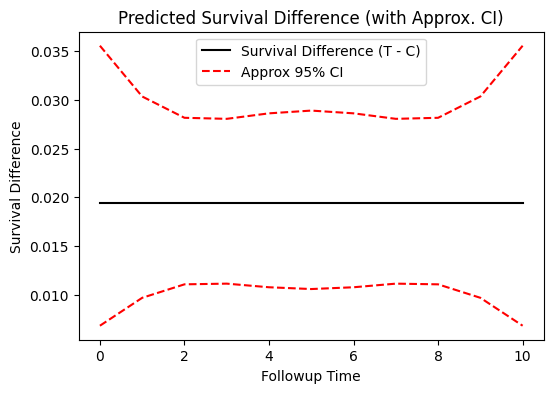

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# =============================================================================
# 1. Load Data
# =============================================================================
# Adjust the file path as needed.
data = pd.read_csv('dataset/data_censored.csv')

# =============================================================================
# 2. Process Data: Compute Weights and Prepare for Survival Analysis
# =============================================================================
def process_estimand(data, estimand_type):
    if estimand_type == 'PP':
        # For Per-Protocol, restrict to eligible patients for the treatment weight model.
        eligible_data = data[data['eligible'] == 1].copy()
        
        # Fit numerator and denominator models for treatment (logistic regression)
        numerator_model = smf.glm('treatment ~ age', eligible_data, 
                                  family=sm.families.Binomial()).fit()
        denominator_model = smf.glm('treatment ~ age + x1 + x3', eligible_data, 
                                    family=sm.families.Binomial()).fit()
        
        # Predict treatment probabilities
        eligible_data['num_prob_tx'] = numerator_model.predict(eligible_data)
        eligible_data['denom_prob_tx'] = denominator_model.predict(eligible_data)
        
        # Compute stabilized treatment weights
        eligible_data['tx_num'] = np.where(eligible_data['treatment'] == 1,
                                          eligible_data['num_prob_tx'],
                                          1 - eligible_data['num_prob_tx'])
        eligible_data['tx_denom'] = np.where(eligible_data['treatment'] == 1,
                                            eligible_data['denom_prob_tx'],
                                            1 - eligible_data['denom_prob_tx'])
        eligible_data['sw_weight'] = eligible_data['tx_num'] / eligible_data['tx_denom']
        
        # Merge back into the full dataset and set missing weights to 1
        sw_weights = eligible_data[['id', 'period', 'sw_weight']]
        data_processed = pd.merge(data, sw_weights, on=['id', 'period'], how='left')
        data_processed.loc[:, 'sw_weight'] = data_processed['sw_weight'].fillna(1)
    else:
        data_processed = data.copy()
        data_processed['sw_weight'] = 1  # No treatment weighting for ITT
    
    # Censoring models: fit numerator and denominator models for censoring
    numerator_formula = 'censored ~ x2'
    denominator_formula = 'censored ~ x2 + x1'
    censor_num_model = smf.glm(numerator_formula, data_processed,
                               family=sm.families.Binomial()).fit()
    censor_denom_model = smf.glm(denominator_formula, data_processed,
                                 family=sm.families.Binomial()).fit()
    
    # Predict censoring probabilities
    data_processed['num_prob_censor'] = censor_num_model.predict(data_processed)
    data_processed['denom_prob_censor'] = censor_denom_model.predict(data_processed)
    
    # Compute censoring weights
    data_processed['cw_num'] = np.where(data_processed['censored'] == 1,
                                        data_processed['num_prob_censor'],
                                        1 - data_processed['num_prob_censor'])
    data_processed['cw_denom'] = np.where(data_processed['censored'] == 1,
                                          data_processed['denom_prob_censor'],
                                          1 - data_processed['denom_prob_censor'])
    data_processed['cw_weight'] = data_processed['cw_num'] / data_processed['cw_denom']
    
    # Compute cumulative weights over periods
    data_sorted = data_processed.sort_values(['id', 'period'])
    data_sorted['cum_sw'] = data_sorted.groupby('id')['sw_weight'].cumprod()
    data_sorted['cum_cw'] = data_sorted.groupby('id')['cw_weight'].cumprod()
    data_sorted['cum_weight'] = data_sorted['cum_sw'] * data_sorted['cum_cw']
    
    # Drop periods after censoring
    data_sorted['censored_ever'] = data_sorted.groupby('id')['censored'].cummax()
    data_filtered = data_sorted[data_sorted['censored_ever'] == 0].copy()
    
    # Winsorize the cumulative weights at the 99th percentile
    q99 = data_filtered['cum_weight'].quantile(0.99)
    data_filtered.loc[:, 'cum_weight_win'] = np.minimum(data_filtered['cum_weight'], q99)
    
    # Prepare for survival analysis: set start, stop, and event variables
    data_filtered.loc[:, 'start'] = data_filtered['period']
    data_filtered.loc[:, 'stop'] = data_filtered['period'] + 1
    data_filtered.loc[:, 'event'] = data_filtered['outcome']
    
    # Mimic trial expansion by setting assigned_treatment equal to treatment
    data_filtered.loc[:, 'assigned_treatment'] = data_filtered['treatment']
    
    return data_filtered

# Process both PP and ITT estimands; here we focus on ITT for outcome modeling.
itt_data = process_estimand(data, 'ITT')

# =============================================================================
# 3. Expand Trials: Create a Trial Sequence (Mimicking R's expand_trials)
# =============================================================================
def expand_trials(data, followup_range=range(0, 11)):
    # For each subject, create a row for each follow-up time in followup_range.
    expanded = []
    for idx, row in data.iterrows():
        for t in followup_range:
            new_row = row.copy()
            # For prediction in R they use outcome_data where trial_period==1
            new_row['trial_period'] = 1  
            new_row['followup_time'] = t
            expanded.append(new_row)
    return pd.DataFrame(expanded)

expanded_data = expand_trials(itt_data)

# =============================================================================
# 4. Fit Outcome Model (Marginal Structural Model)
# =============================================================================
# We mimic the R outcome model, which (after expansion) typically uses a logistic regression.
# The R formula (for ITT) is roughly:
# outcome ~ assigned_treatment + x2 + followup_time + I(followup_time^2) + trial_period + I(trial_period^2)
formula = ("outcome ~ assigned_treatment + x2 + followup_time + "
           "I(followup_time**2) + trial_period + I(trial_period**2)")
# Fit the weighted logistic regression using frequency weights (cum_weight_win)
outcome_model = smf.glm(formula, data=expanded_data, 
                        family=sm.families.Binomial(),
                        freq_weights=expanded_data['cum_weight_win']).fit()
print(outcome_model.summary())

# =============================================================================
# 5. Inference: Predict Survival Probabilities and Compute Survival Difference
# =============================================================================
# In R, the outcome model is used to predict survival probabilities.
# Here we assume that the predicted probability from the logistic model is the risk of the event by that time,
# so survival probability is computed as 1 - risk.

# Create new prediction data (using the expanded outcome data where trial_period==1)
followup_range = np.arange(0, 11)
x2_mean = itt_data['x2'].mean()

# Create separate new datasets for control and treatment groups:
df_control = pd.DataFrame({
    'followup_time': followup_range,
    'trial_period': 1,
    'x2': x2_mean,
    'assigned_treatment': 0
})
df_treatment = pd.DataFrame({
    'followup_time': followup_range,
    'trial_period': 1,
    'x2': x2_mean,
    'assigned_treatment': 1
})

# Get predictions (with confidence intervals) from the outcome model
pred_control = outcome_model.get_prediction(df_control)
pred_treatment = outcome_model.get_prediction(df_treatment)

pred_control_summary = pred_control.summary_frame(alpha=0.05)
pred_treatment_summary = pred_treatment.summary_frame(alpha=0.05)

# Convert predicted risk into survival probabilities:
surv_control = 1 - pred_control_summary['mean']
surv_treatment = 1 - pred_treatment_summary['mean']

# Compute survival difference (Treatment minus Control)
surv_diff = surv_treatment - surv_control

# For an approximate 95% CI, we use a conservative approach:
# Lower bound: treatment lower CI - control upper CI; Upper bound: treatment upper CI - control lower CI.
surv_diff_lower = (1 - pred_treatment_summary['mean_ci_upper']) - (1 - pred_control_summary['mean_ci_lower'])
surv_diff_upper = (1 - pred_treatment_summary['mean_ci_lower']) - (1 - pred_control_summary['mean_ci_upper'])

# =============================================================================
# 6. Plot the Survival Difference over Followup Time
# =============================================================================
plt.figure(figsize=(6,4))
plt.plot(followup_range, surv_diff, 'k-', label="Survival Difference (T - C)")
plt.plot(followup_range, surv_diff_lower, 'r--', label="Approx 95% CI")
plt.plot(followup_range, surv_diff_upper, 'r--')
plt.xlabel("Followup Time")
plt.ylabel("Survival Difference")
plt.title("Predicted Survival Difference (with Approx. CI)")
plt.legend()
plt.show()
